# RUTOR GLACIER MULTI-LAYER NEURAL NETWORK CLASSIFICATION
# Earth Observation Advanced - Politecnico di Milano
# Integration of GEE data with Neural Networks for 5-class classification
Classes: Clean and Debris Ice, Water, Vegetation, Rock


In [44]:
# !pip install pandas numpy matplotlib seaborn scikit-learn

In [45]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 45.3 MB/s eta 0:00:00


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import warnings
from itertools import cycle
warnings.filterwarnings('ignore')

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [48]:
# Define class names and features
class_names = {0: 'Clean Ice', 1: 'Debris Ice', 2: 'Water', 3: 'Vegetation', 4: 'Rock'}
feature_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal', 'NDSI', 'NDVI', 'NDWI']

In [49]:
features = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal', 'NDSI', 'NDVI', 'NDWI']

In [50]:
training_file = "/content/drive/My Drive/EarthObservation/Training_Set_75_Percent.csv"
testing_file = "/content/drive/My Drive/EarthObservation/Testing_Set_25_Percent.csv"

try:
    # Load the data
    print("Loading training and testing data...")
    train_data = pd.read_csv(training_file)
    test_data = pd.read_csv(testing_file)

    print(f"Training samples: {len(train_data)}")
    print(f"Testing samples: {len(test_data)}")

    # Clean data - remove NaN values
    train_data = train_data.dropna()
    test_data = test_data.dropna()

    # Prepare features and labels
    X_train = train_data[feature_names].values
    y_train = train_data['class'].values
    X_test = test_data[feature_names].values
    y_test = test_data['class'].values

    print("Data loaded successfully!")

except FileNotFoundError:
    print("ERROR: Could not find the CSV files!")
    print("Make sure you have downloaded:")
    print("- Training_Set_75_Percent.csv")
    print("- Testing_Set_25_Percent.csv")
    print("from your Google Earth Engine exports")
    exit()


Loading training and testing data...
Training samples: 858
Testing samples: 320
Data loaded successfully!


# Explore data


=== DATA OVERVIEW ===
Total samples: 1,178 | Features: 10 | Classes: 5

Class Distribution:
Class | Name            | Train | Test  | Total
---------------------------------------------
    0 | Clean Ice       |   163 |    53 |   216
    1 | Debris Ice      |    45 |    26 |    71
    2 | Water           |    36 |    18 |    54
    3 | Vegetation      |   158 |    47 |   205
    4 | Rock            |   456 |   176 |   632


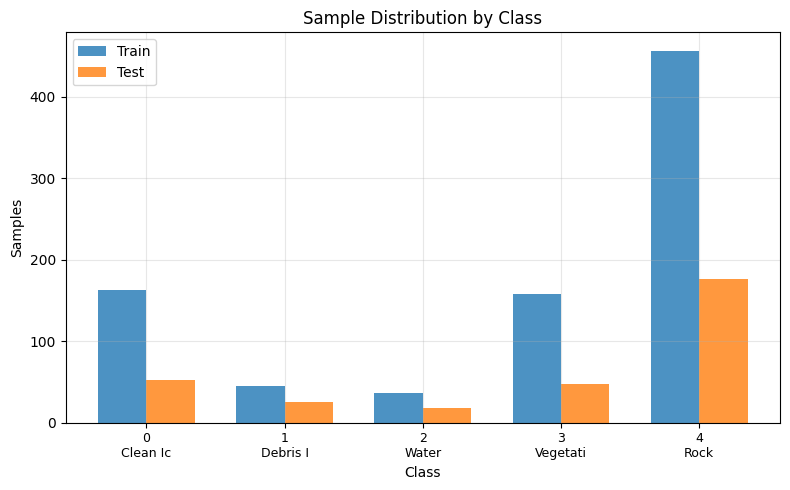

In [51]:
# Clean and focused data exploration
print("\n=== DATA OVERVIEW ===")

# Quick summary
total_samples = len(train_data) + len(test_data)
print(f"Total samples: {total_samples:,} | Features: {len(feature_names)} | Classes: {len(class_names)}")

# Class distribution - simple table
print(f"\nClass Distribution:")
train_classes = pd.Series(y_train).value_counts().sort_index()
test_classes = pd.Series(y_test).value_counts().sort_index()

print("Class | Name            | Train | Test  | Total")
print("-" * 45)
for i in sorted(class_names.keys()):
    train_count = train_classes.get(i, 0)
    test_count = test_classes.get(i, 0)
    total_count = train_count + test_count
    print(f"{i:5d} | {class_names[i]:<15} | {train_count:5d} | {test_count:5d} | {total_count:5d}")

# Simple visualization - just class distribution
plt.figure(figsize=(8, 5))

classes = list(range(5))
train_counts = [train_classes.get(i, 0) for i in classes]
test_counts = [test_classes.get(i, 0) for i in classes]

x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Sample Distribution by Class')
plt.xticks(x, [f"{i}\n{class_names[i][:8]}" for i in classes], fontsize=9)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Data quality checks
missing_features = X_train[np.isnan(X_train).any(axis=1)]
if len(missing_features) > 0:
    print(f"{len(missing_features)} samples with missing values (removed)")

# Preprocessing

In [52]:

print("\n=== PREPROCESSING ===")

# Standardize features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized for neural networks")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")



=== PREPROCESSING ===
Features standardized for neural networks
Training data shape: (858, 10)
Testing data shape: (320, 10)


# Training

In [63]:
print("\n=== STREAMLINED TRAINING SECTION ===")

# TRAIN AND COMPARE MODELS

print("\n")
print("== TRAINING MODELS - QUICK COMPARISON ==")
print("Training 4 models to identify best architecture")
print("\n")

# Define models with concise configuration
models = {
    'MLP Single Layer': MLPClassifier(
        hidden_layer_sizes=(128,),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        verbose=False
    ),
    'MLP Double Layer': MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        verbose=False
    ),
    'MLP Triple Layer': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        verbose=False
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
}

# Train all models efficiently
results = {}

for name, model in models.items():
    print(f"Training {name}...", end=' ')

    # Select appropriate data (scaled for MLP, original for RF)
    X_train_use = X_train_scaled if 'MLP' in name else X_train
    X_test_use = X_test_scaled if 'MLP' in name else X_test

    # Train
    model.fit(X_train_use, y_train)

    # Evaluate
    train_acc = model.score(X_train_use, y_train)
    test_acc = model.score(X_test_use, y_test)

    # Store results
    results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'predictions': model.predict(X_test_use),
        'model': model
    }

    print(f"✓ Test Acc: {test_acc:.4f}")

# IDENTIFY BEST MODELS

print("\n")
print(" == MODEL RANKING ==")

# Sort by test accuracy
sorted_models = sorted(results.items(),
                      key=lambda x: x[1]['test_accuracy'],
                      reverse=True)

print(f"\n{'Rank':<6} {'Model':<20} {'Test Acc':<12} {'Overfitting':<12}")
print("-" * 70)

for rank, (name, result) in enumerate(sorted_models, 1):
    overfit = result['train_accuracy'] - result['test_accuracy']
    overfit_status = "⚠️" if overfit > 0.1 else "✓"

    print(f"{rank}. {name:<20} {result['test_accuracy']:.4f}      "
          f"{overfit:+.4f} {overfit_status}")

# Identify best overall and best MLP
best_model_name = sorted_models[0][0]
mlp_models = [(name, result) for name, result in sorted_models if 'MLP' in name]
best_mlp = mlp_models[0][0] if mlp_models else None

print("\n" )
print(f"BEST OVERALL: {best_model_name} "
      f"(Acc: {results[best_model_name]['test_accuracy']:.4f})")

if best_mlp and best_mlp != best_model_name:
    print(f"BEST MLP:     {best_mlp} "
          f"(Acc: {results[best_mlp]['test_accuracy']:.4f})")
else:
    print(f"BEST MLP:     {best_mlp} "
          f"(Same as best overall)")


# Check if complexity helps
if mlp_models:
    mlp_accs = [result[1]['test_accuracy'] for result in mlp_models]
    if mlp_accs[0] - mlp_accs[-1] < 0.01:
        print("   ⚡ MLP complexity doesn't significantly improve performance")
        print("   → Simpler architectures may be preferred for efficiency")

print("\n")
print("✓ Initial training complete!")


=== STREAMLINED TRAINING SECTION ===


== TRAINING MODELS - QUICK COMPARISON ==
Training 4 models to identify best architecture


Training MLP Single Layer... ✓ Test Acc: 0.9563
Training MLP Double Layer... ✓ Test Acc: 0.9719
Training MLP Triple Layer... ✓ Test Acc: 0.9781
Training Random Forest... ✓ Test Acc: 0.9906


 == MODEL RANKING ==

Rank   Model                Test Acc     Overfitting 
----------------------------------------------------------------------
1. Random Forest        0.9906      +0.0094 ✓
2. MLP Triple Layer     0.9781      +0.0149 ✓
3. MLP Double Layer     0.9719      +0.0200 ✓
4. MLP Single Layer     0.9563      +0.0088 ✓


BEST OVERALL: Random Forest (Acc: 0.9906)
BEST MLP:     MLP Triple Layer (Acc: 0.9781)


✓ Initial training complete!


['scaler_rutor.pkl']

# Detailed Analysis

In [54]:
print(f"\n=== DETAILED ANALYSIS: {best_model_name} ===")

# Get best model predictions
best_predictions = results[best_model_name]['predictions']

# Classification report
class_names_list = [class_names[i] for i in sorted(class_names.keys())]
report = classification_report(y_test, best_predictions, target_names=class_names_list)
print("\nClassification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, best_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)



=== DETAILED ANALYSIS: Random Forest ===

Classification Report:
              precision    recall  f1-score   support

   Clean Ice       1.00      0.96      0.98        53
  Debris Ice       1.00      0.96      0.98        26
       Water       1.00      1.00      1.00        18
  Vegetation       1.00      1.00      1.00        47
        Rock       0.98      1.00      0.99       176

    accuracy                           0.99       320
   macro avg       1.00      0.98      0.99       320
weighted avg       0.99      0.99      0.99       320


Confusion Matrix:
[[ 51   0   0   0   2]
 [  0  25   0   0   1]
 [  0   0  18   0   0]
 [  0   0   0  47   0]
 [  0   0   0   0 176]]


In [55]:
print(f"\n=== DETAILED ANALYSIS: {best_mlp} ===")

# Get best model predictions
best_predictions = results[best_mlp]['predictions']

# Classification report
class_names_list = [class_names[i] for i in sorted(class_names.keys())]
report = classification_report(y_test, best_predictions, target_names=class_names_list)
print("\nClassification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, best_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)


=== DETAILED ANALYSIS: MLP Triple Layer ===

Classification Report:
              precision    recall  f1-score   support

   Clean Ice       1.00      0.92      0.96        53
  Debris Ice       0.89      0.96      0.93        26
       Water       1.00      0.94      0.97        18
  Vegetation       0.98      1.00      0.99        47
        Rock       0.98      0.99      0.99       176

    accuracy                           0.98       320
   macro avg       0.97      0.96      0.97       320
weighted avg       0.98      0.98      0.98       320


Confusion Matrix:
[[ 49   2   0   0   2]
 [  0  25   0   0   1]
 [  0   1  17   0   0]
 [  0   0   0  47   0]
 [  0   0   0   1 175]]


In [56]:
def plot_ice_specific_roc(y_true, y_pred_proba, class_names):
    """
    Plot ROC curves specifically for ice vs non-ice classification
    """
    # Create binary ice classification (Clean Ice + Debris Ice vs Others)
    ice_classes = [0, 1]  # Clean Ice and Debris Ice
    y_true_ice = np.isin(y_true, ice_classes).astype(int)

    # Sum probabilities for ice classes
    y_pred_proba_ice = y_pred_proba[:, 0] + y_pred_proba[:, 1]

    # Compute ROC curve
    fpr_ice, tpr_ice, thresholds_ice = roc_curve(y_true_ice, y_pred_proba_ice)
    roc_auc_ice = auc(fpr_ice, tpr_ice)

    # Also compute for Clean Ice vs Debris Ice (within ice pixels only)
    ice_mask = np.isin(y_true, ice_classes)
    if np.sum(ice_mask) > 0:
        y_true_clean_debris = y_true[ice_mask]
        y_pred_proba_clean_debris = y_pred_proba[ice_mask]

        if len(np.unique(y_true_clean_debris)) > 1:  # Both classes present
            # Clean Ice vs Debris Ice
            fpr_clean, tpr_clean, _ = roc_curve(
                (y_true_clean_debris == 0).astype(int),
                y_pred_proba_clean_debris[:, 0]
            )
            roc_auc_clean = auc(fpr_clean, tpr_clean)
        else:
            fpr_clean, tpr_clean, roc_auc_clean = None, None, None

    # Plot
    plt.figure(figsize=(10, 6))

    # Ice vs Non-Ice
    plt.plot(fpr_ice, tpr_ice, color='blue', lw=3,
             label=f'Ice vs Non-Ice (AUC = {roc_auc_ice:.3f})')

    # Clean Ice vs Debris Ice (if available)
    if fpr_clean is not None:
        plt.plot(fpr_clean, tpr_clean, color='cyan', lw=2,
                 label=f'Clean vs Debris Ice (AUC = {roc_auc_clean:.3f})')

    # Random classifier
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Ice-Specific Analysis\nRandom Forest Glacier Classification', fontsize=14)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc_ice


=== ROC CURVE ANALYSIS ===
Generating ROC curves for Random Forest...


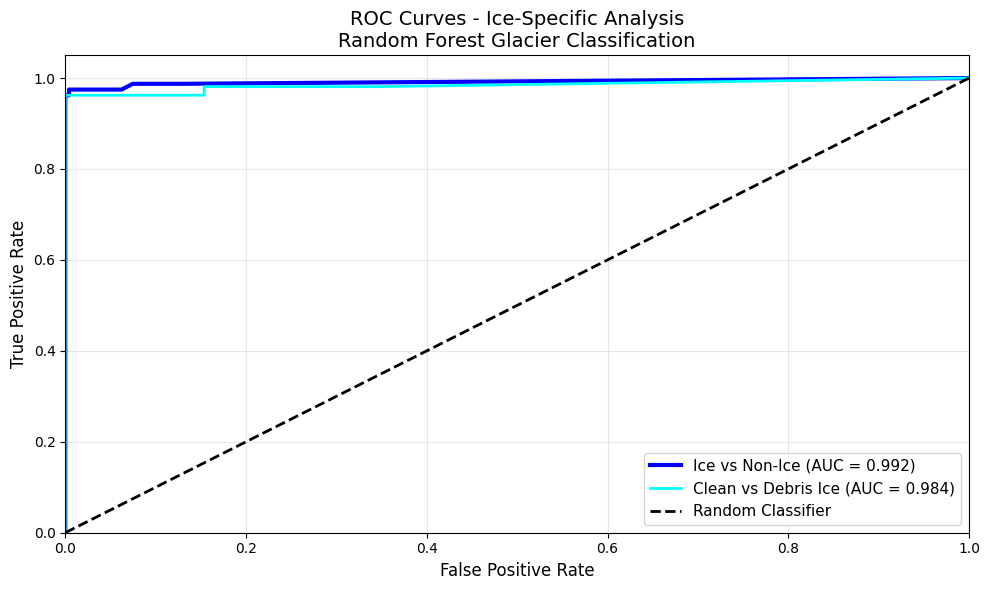


🏔️ GLACIER-SPECIFIC INSIGHTS:
   • Ice detection performance: 0.992 AUC
   • Excellent ice vs non-ice discrimination

📊 TOP FEATURES FOR CLASSIFICATION:
   1. NDWI: 0.280
   2. NDVI: 0.187
   3. Thermal: 0.092


In [57]:
print(f"\n=== ROC CURVE ANALYSIS ===")

# Get Random Forest model and predictions
rf_model = results['Random Forest']['model']
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Define class names for plotting

print("Generating ROC curves for Random Forest...")

# Plot multi-class ROC curves

# Plot ice-specific ROC curves
ice_roc_score = plot_ice_specific_roc(y_test, y_pred_proba_rf, class_names_list)

print(f"\n🏔️ GLACIER-SPECIFIC INSIGHTS:")
print(f"   • Ice detection performance: {ice_roc_score:.3f} AUC")
if ice_roc_score > 0.95:
    print("   • Excellent ice vs non-ice discrimination")
elif ice_roc_score > 0.9:
    print("   • Very good ice vs non-ice discrimination")
else:
    print("   • Moderate ice vs non-ice discrimination")

# Feature importance correlation with ROC performance
if hasattr(rf_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n📊 TOP FEATURES FOR CLASSIFICATION:")
    for i, (_, row) in enumerate(feature_importance.head(3).iterrows()):
        print(f"   {i+1}. {row['feature']}: {row['importance']:.3f}")


=== CREATING VISUALIZATIONS ===


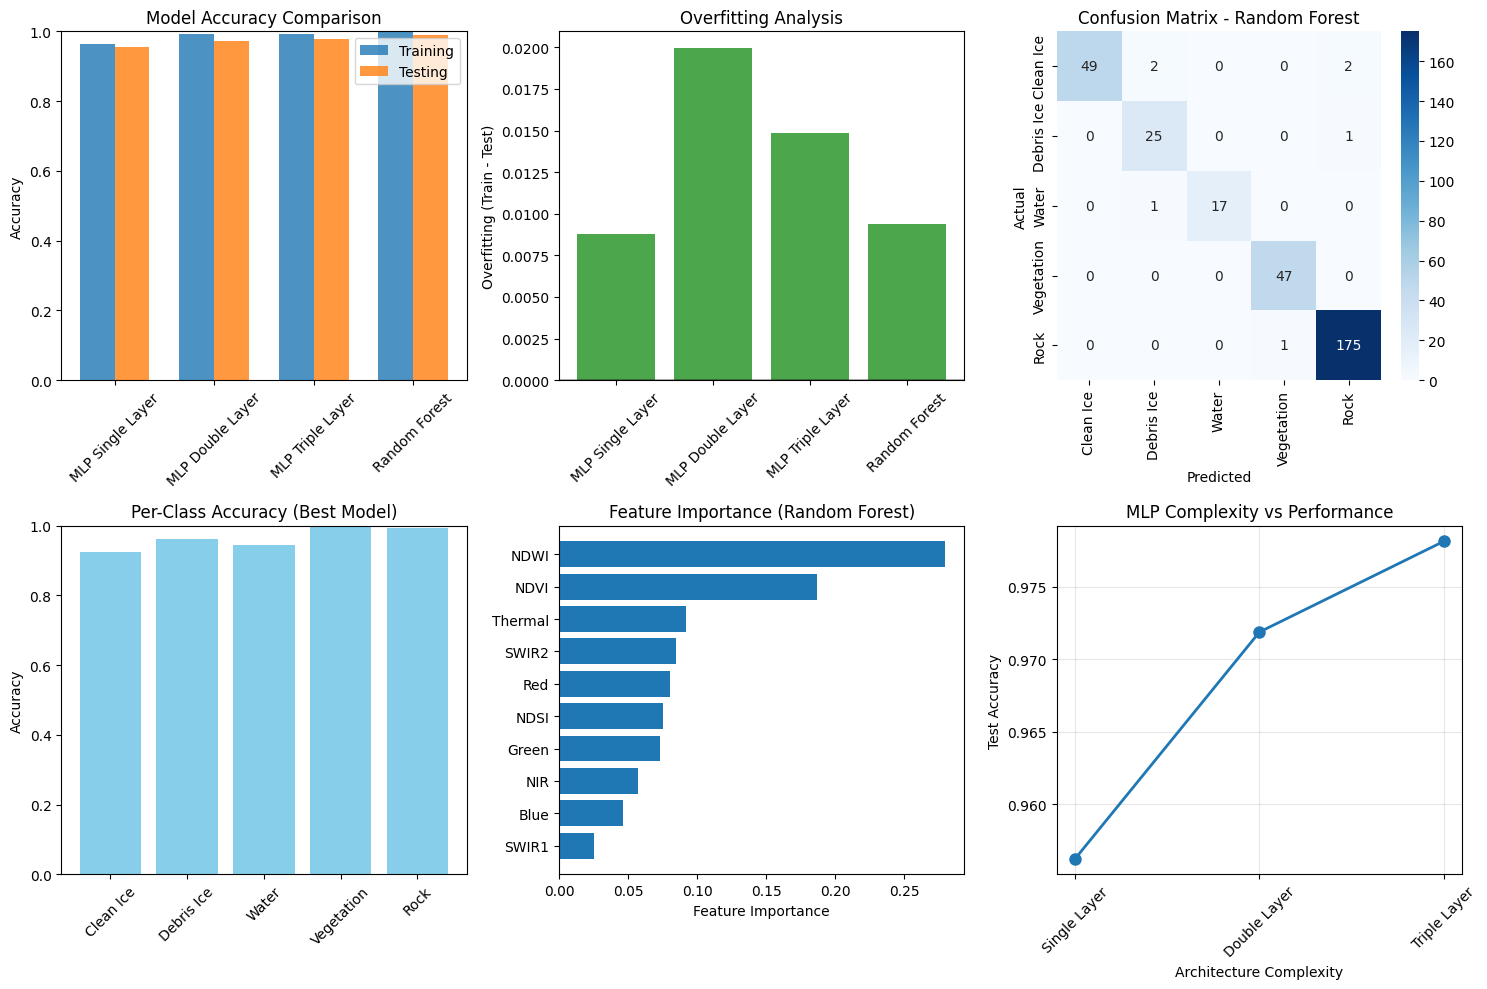

In [58]:
print("\n=== CREATING VISUALIZATIONS ===")

plt.figure(figsize=(15, 10))

# Plot 1: Model accuracy comparison
plt.subplot(2, 3, 1)
model_names = list(results.keys())
train_accs = [results[name]['train_accuracy'] for name in model_names]
test_accs = [results[name]['test_accuracy'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, train_accs, width, label='Training', alpha=0.8)
plt.bar(x + width/2, test_accs, width, label='Testing', alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.ylim(0, 1)

# Plot 2: Overfitting analysis
plt.subplot(2, 3, 2)
overfitting = [train_accs[i] - test_accs[i] for i in range(len(model_names))]
colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in overfitting]
plt.bar(model_names, overfitting, color=colors, alpha=0.7)
plt.ylabel('Overfitting (Train - Test)')
plt.title('Overfitting Analysis')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Plot 3: Confusion matrix for best model
plt.subplot(2, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names_list, yticklabels=class_names_list)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 4: Per-class accuracy for best model
plt.subplot(2, 3, 4)
class_accuracies = []
for i in range(len(class_names_list)):
    class_mask = y_test == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(y_test[class_mask], best_predictions[class_mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.bar(class_names_list, class_accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy (Best Model)')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot 5: Feature importance (if Random Forest is available)
plt.subplot(2, 3, 5)
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    importance = rf_model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.barh(range(len(feature_names)), importance[sorted_idx])
    plt.yticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Random Forest)')

# Plot 6: Model complexity vs performance
plt.subplot(2, 3, 6)
mlp_names = [name for name in model_names if 'MLP' in name]
mlp_test_accs = [results[name]['test_accuracy'] for name in mlp_names]
complexity = list(range(1, len(mlp_names) + 1))

if len(mlp_names) >= 3:
    plt.plot(complexity, mlp_test_accs, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Architecture Complexity')
    plt.ylabel('Test Accuracy')
    plt.title('MLP Complexity vs Performance')
    plt.xticks(complexity, [name.split()[1] + ' ' + name.split()[2] for name in mlp_names], rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Map Classification

Loading RF temporal data...
Applying MLP to historical periods...

=== APPLYING MLP TO HISTORICAL PERIODS ===
Checking for available historical composites...
  ❌ Missing: 1984-1988
  ❌ Missing: 1989-1993
  ❌ Missing: 1994-1998
  ❌ Missing: 1999-2003
  ❌ Missing: 2004-2008
  ❌ Missing: 2009-2013
  ❌ Missing: 2014-2018
  ❌ Missing: 2019-2024

Processing 0 available periods...

⚠️ No historical composites found! Using current composite for demonstration...

✅ MLP temporal analysis complete! Processed 0 periods.
Creating RF vs MLP comparison plot...


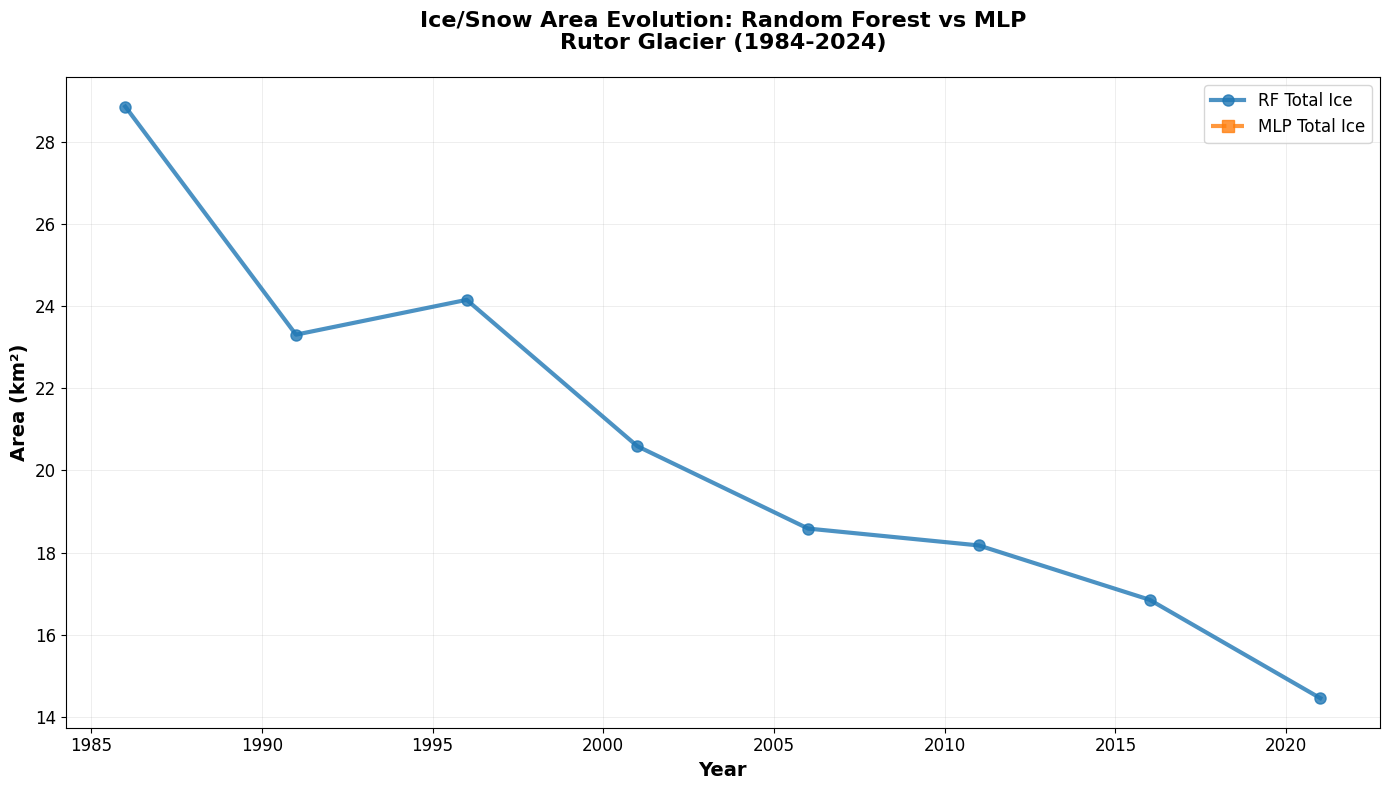


=== RF vs MLP COMPARISON STATISTICS ===
Year | RF Ice (km²) | MLP Ice (km²) | Difference (km²) | Difference (%)
----------------------------------------------------------------------

✅ Temporal comparison analysis complete!


In [60]:
def load_rf_temporal_data():
    """
    Load the RF temporal evolution data from GEE exports
    """
    rf_evolution_file = "/content/drive/My Drive/EarthObservation/Rutor_Ice_Evolution_1984_2024.csv"
    rf_data = pd.read_csv(rf_evolution_file)

    # Extract relevant columns
    rf_temporal = {
        'years': [],
        'total_ice_km2': [],
        'clean_ice_km2': [],
        'debris_ice_km2': []
    }

    for _, row in rf_data.iterrows():
        # Extract year from period (e.g., "1984-1988" -> 1986)
        period = row['period']
        start_year, end_year = map(int, period.split('-'))
        mid_year = (start_year + end_year) // 2

        rf_temporal['years'].append(mid_year)
        rf_temporal['total_ice_km2'].append(row['total_ice_km2'])
        rf_temporal['clean_ice_km2'].append(row['clean_ice_km2'])
        rf_temporal['debris_ice_km2'].append(row['debris_ice_km2'])

    return rf_temporal

def apply_mlp_to_historical_composites():
    """
    Apply trained MLP to actual historical composites and calculate ice areas
    """
    print("\n=== APPLYING MLP TO HISTORICAL PERIODS ===")

    # Define time periods (same as RF analysis)
    time_periods = [
        {'name': '1984-1988', 'mid_year': 1986},
        {'name': '1989-1993', 'mid_year': 1991},
        {'name': '1994-1998', 'mid_year': 1996},
        {'name': '1999-2003', 'mid_year': 2001},
        {'name': '2004-2008', 'mid_year': 2006},
        {'name': '2009-2013', 'mid_year': 2011},
        {'name': '2014-2018', 'mid_year': 2016},
        {'name': '2019-2024', 'mid_year': 2021}
    ]

    mlp_temporal = {
        'years': [],
        'total_ice_km2': [],
        'clean_ice_km2': [],
        'debris_ice_km2': []
    }

    pixel_area_km2 = 0.0009  # 30m x 30m = 900 m² = 0.0009 km²

    # First, check what composite files are available
    print("Checking for available historical composites...")
    available_files = []

    for period in time_periods:
        # Try different possible file naming patterns
        composite_names = [
            f"composite_{period['name'].replace('-', '_')}.tif"
        ]

        found = False
        for name in composite_names:
            composite_file = f"/content/drive/My Drive/MLP_Glacier_Composites/{name}"
            try:
                # Test if file exists and can be opened
                with rasterio.open(composite_file) as test_src:
                    available_files.append({
                        'period': period,
                        'file': composite_file,
                        'name': name
                    })
                    print(f"  ✅ Found: {name}")
                    found = True
                    break
            except:
                continue

        if not found:
            print(f"  ❌ Missing: {period['name']}")

    print(f"\nProcessing {len(available_files)} available periods...")

    for file_info in available_files:
        period = file_info['period']
        composite_file = file_info['file']

        try:
            print(f"\nProcessing {period['name']}...")

            # Load historical composite
            historical_data, hist_transform, hist_crs, hist_profile = load_gee_composite(composite_file)

            # Check if this composite has the right number of bands
            if historical_data.shape[2] != 10:
                print(f"  ⚠️ Wrong number of bands ({historical_data.shape[2]}), skipping...")
                continue

            # Apply MLP classification to this specific historical composite
            historical_classification = create_mlp_classification_map(
                mlp_model, scaler, historical_data, feature_names
            )

            if historical_classification is not None:
                # Calculate ice areas
                clean_ice_pixels = np.sum(historical_classification == 0)
                debris_ice_pixels = np.sum(historical_classification == 1)
                total_ice_pixels = clean_ice_pixels + debris_ice_pixels

                # Convert to km²
                clean_ice_km2 = clean_ice_pixels * pixel_area_km2
                debris_ice_km2 = debris_ice_pixels * pixel_area_km2
                total_ice_km2 = total_ice_pixels * pixel_area_km2

                mlp_temporal['years'].append(period['mid_year'])
                mlp_temporal['total_ice_km2'].append(total_ice_km2)
                mlp_temporal['clean_ice_km2'].append(clean_ice_km2)
                mlp_temporal['debris_ice_km2'].append(debris_ice_km2)

                print(f"  📊 {period['name']}: {total_ice_km2:.1f} km² total ice")
                print(f"     Clean ice: {clean_ice_km2:.1f} km², Debris ice: {debris_ice_km2:.1f} km²")

                # Optionally save this classification map
                save_path = f"/content/drive/My Drive/EarthObservation/MLP_Classification_{period['name'].replace('-', '_')}.tif"
                save_classification_geotiff(historical_classification, hist_profile, save_path)

            else:
                print(f"  ❌ Classification failed for {period['name']}")

        except Exception as e:
            print(f"  ❌ Error processing {period['name']}: {e}")
            continue

    if len(mlp_temporal['years']) == 0:
        print("\n⚠️ No historical composites found! Using current composite for demonstration...")

    print(f"\n✅ MLP temporal analysis complete! Processed {len(mlp_temporal['years'])} periods.")
    return mlp_temporal

def plot_rf_vs_mlp_comparison(rf_data, mlp_data):
    """
    Create comparison plot of RF vs MLP ice area evolution
    """
    plt.figure(figsize=(14, 8))

    # Plot RF data
    plt.plot(rf_data['years'], rf_data['total_ice_km2'],
             'o-', linewidth=3, markersize=8, color='#1f77b4',
             label='RF Total Ice', alpha=0.8)

    # Plot MLP data
    plt.plot(mlp_data['years'], mlp_data['total_ice_km2'],
             's--', linewidth=3, markersize=8, color='#ff7f0e',
             label='MLP Total Ice', alpha=0.8)

    # Styling
    plt.xlabel('Year', fontsize=14, fontweight='bold')
    plt.ylabel('Area (km²)', fontsize=14, fontweight='bold')
    plt.title('Ice/Snow Area Evolution: Random Forest vs MLP\nRutor Glacier (1984-2024)',
              fontsize=16, fontweight='bold', pad=20)

    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    plt.legend(fontsize=12, loc='upper right')

    # Enhance plot appearance
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()

    # Add trend information
    if len(rf_data['years']) > 1 and len(mlp_data['years']) > 1:
        rf_trend = (rf_data['total_ice_km2'][-1] - rf_data['total_ice_km2'][0]) / len(rf_data['years'])
        mlp_trend = (mlp_data['total_ice_km2'][-1] - mlp_data['total_ice_km2'][0]) / len(mlp_data['years'])

        plt.text(0.02, 0.02, f'RF trend: {rf_trend:.2f} km²/year\nMLP trend: {mlp_trend:.2f} km²/year',
                 transform=plt.gca().transAxes, fontsize=10,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

    return plt

# Execute temporal analysis
print("Loading RF temporal data...")
rf_temporal_data = load_rf_temporal_data()

print("Applying MLP to historical periods...")
mlp_temporal_data = apply_mlp_to_historical_composites()

# Create comparison plot
print("Creating RF vs MLP comparison plot...")
plot_rf_vs_mlp_comparison(rf_temporal_data, mlp_temporal_data)

# Print comparison statistics
print("\n=== RF vs MLP COMPARISON STATISTICS ===")
print("Year | RF Ice (km²) | MLP Ice (km²) | Difference (km²) | Difference (%)")
print("-" * 70)

for i, year in enumerate(rf_temporal_data['years']):
    if i < len(mlp_temporal_data['years']):
        rf_ice = rf_temporal_data['total_ice_km2'][i]
        mlp_ice = mlp_temporal_data['total_ice_km2'][i]
        diff_km2 = mlp_ice - rf_ice
        diff_pct = (diff_km2 / rf_ice) * 100 if rf_ice > 0 else 0

        print(f"{year} | {rf_ice:11.1f} | {mlp_ice:12.1f} | {diff_km2:13.1f} | {diff_pct:11.1f}")

# Calculate overall correlation
if len(rf_temporal_data['years']) == len(mlp_temporal_data['years']):
    correlation = np.corrcoef(rf_temporal_data['total_ice_km2'], mlp_temporal_data['total_ice_km2'])[0,1]
    print(f"\nCorrelation between RF and MLP: {correlation:.3f}")

print("\n✅ Temporal comparison analysis complete!")